<a href="https://colab.research.google.com/github/hosngholami/RecommenderSystem/blob/main/RecommenderSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install opendatasets
!pip install geopy
!pip install folium
!pip install -U pymoo


In [7]:
import pandas as pd
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors

pd.set_option("display.max_columns", 1000)
pd.set_option('display.max_rows', 1000)
np.set_printoptions(threshold=np.inf)

In [8]:
import random
import matplotlib.pyplot as plt
locations = pd.read_csv('/content/drive/MyDrive/Shiraz/locations.csv')
locations["Id"] = [i for i in range(0, len(locations))]
locations["Stars"] = 0
locations["Price"] = 0
# locations["Price"] = [random.randint(10, 200) for i in range(len(locations))]

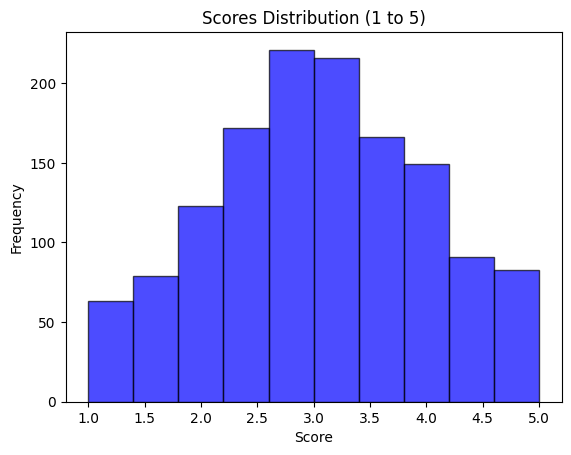

In [9]:
mean_score = 3  # میانگین امتیاز (در وسط بازه 1 تا 5)
std_dev = 1     # انحراف معیار امتیاز

# تعداد آیتم‌ها
num_items = len(locations)

# تولید امتیازات خام با توزیع نرمال
raw_scores = np.random.normal(mean_score, std_dev, num_items)
scores = np.clip(raw_scores, 1, 5)
data = pd.DataFrame({'Item': [f'Item_{i+1}' for i in range(num_items)], 'Score': scores})

# مرتب‌سازی بر اساس امتیاز و اختصاص رتبه
data = data.sort_values(by='Score', ascending=False).reset_index(drop=True)
data['Rank'] = data.index + 1

# رسم هیستوگرام امتیازات
plt.hist(scores, bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Scores Distribution (1 to 5)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

locations["Stars"] = scores

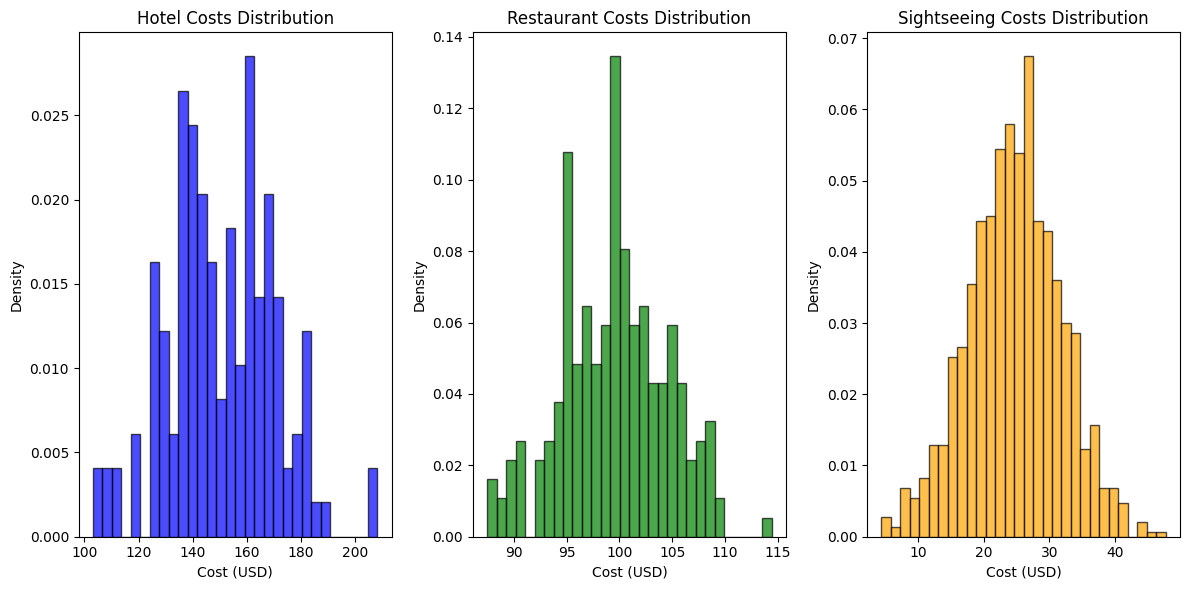

In [10]:
import numpy as np


# تعداد مکان‌ها
num_hotels = len(locations[locations["type"] == "hotel"])         # تعداد هتل‌ها
num_restaurants = len(locations[locations["type"] == "restaurant"])    # تعداد رستوران‌ها
num_sightseeing = len(locations[~locations["type"].isin(['hotel', 'restaurant'])])    # تعداد مکان‌های دیدنی

# پارامترهای توزیع نرمال برای هزینه‌های واحد
# هزینه هتل
mean_hotel = 150  # میانگین هزینه هر هتل (دلار)
std_hotel = 20    # انحراف معیار هزینه هر هتل

# هزینه رستوران
mean_restaurant = 100  # میانگین هزینه هر رستوران (دلار)
std_restaurant = 5    # انحراف معیار هزینه هر رستوران

# هزینه مکان‌های دیدنی
mean_sightseeing = 25  # میانگین هزینه هر مکان دیدنی (دلار)
std_sightseeing = 7     # انحراف معیار هزینه هر مکان دیدنی

# تولید هزینه‌ها برای هر بخش
hotel_costs = np.random.normal(mean_hotel, std_hotel, num_hotels)
restaurant_costs = np.random.normal(mean_restaurant, std_restaurant, num_restaurants)
sightseeing_costs = np.random.normal(mean_sightseeing, std_sightseeing, num_sightseeing)

# رسم نمودار توزیع نرمال برای هر بخش
plt.figure(figsize=(12, 6))

# نمودار هتل‌ها
plt.subplot(1, 3, 1)
plt.hist(hotel_costs, bins=30, color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title('Hotel Costs Distribution')
plt.xlabel('Cost (USD)')
plt.ylabel('Density')

# نمودار رستوران‌ها
plt.subplot(1, 3, 2)
plt.hist(restaurant_costs, bins=30, color='green', alpha=0.7, edgecolor='black', density=True)
plt.title('Restaurant Costs Distribution')
plt.xlabel('Cost (USD)')
plt.ylabel('Density')

# نمودار مکان‌های دیدنی
plt.subplot(1, 3, 3)
plt.hist(sightseeing_costs, bins=30, color='orange', alpha=0.7, edgecolor='black', density=True)
plt.title('Sightseeing Costs Distribution')
plt.xlabel('Cost (USD)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()



indexHotel = locations[locations["type"] == "hotel"].index

for i in indexHotel:
   locations.loc[i, "Price"] = int(hotel_costs[i])

indexRestaurant = locations[locations["type"] == "restaurant"].index

c = 0
for i in indexRestaurant:
   locations.loc[i, "Price"] = restaurant_costs[c]
   c += 1


c = 0
indexSightseeing = locations[~locations["type"].isin(['hotel', 'restaurant'])].index
for i in indexSightseeing:
   locations.loc[i, "Price"] = sightseeing_costs[c]
   c +=1



In [ ]:
set(locations["type"])

{'caffe',
 'historic',
 'hotel',
 'museum',
 'park',
 'placeofworship',
 'restaurant',
 'swimmingpool'}

In [11]:
def getLocation():
   location = locations[locations["type"] != "hotel"].sample(n=1)
   return location["Id"].values[0]

In [12]:
class GeneticAlgorithmConfig():
  totalLocationSize = 1
  hotelSize = 1
  numberLocationSize = len(locations[locations["type"] != "hotel"])
  timePlaceMappingSize = 2
  n_var = ((numberLocationSize * timePlaceMappingSize) +
         (hotelSize * timePlaceMappingSize) +
         (totalLocationSize))

In [13]:
def getSliceRoute(route):
  length = route[0] * GeneticAlgorithmConfig.timePlaceMappingSize
  startHead = GeneticAlgorithmConfig.hotelSize
  endHead = (GeneticAlgorithmConfig.hotelSize * GeneticAlgorithmConfig.timePlaceMappingSize) + GeneticAlgorithmConfig.totalLocationSize

  startTail = length + endHead
  endTail  = length + endHead + GeneticAlgorithmConfig.timePlaceMappingSize
  interior = []
  if(route[0] != 0):
      interior = route[endHead:startTail]

  return (route[startHead:endHead], interior, route[startTail:endTail])

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     16 |             - |             -
     2 |      200 |     20 |  0.2593776273 |         ideal
     3 |      300 |     22 |  0.1451249278 |         ideal
     4 |      400 |     25 |  0.0684924211 |             f
     5 |      500 |     33 |  0.0194738134 |         ideal
     6 |      600 |     35 |  0.1645855803 |         ideal
     7 |      700 |     40 |  0.1810563143 |         ideal
     8 |      800 |     57 |  0.2375048630 |         ideal
     9 |      900 |     65 |  0.0932093217 |         ideal
    10 |     1000 |     64 |  0.0418263972 |         ideal
    11 |     1100 |     75 |  0.1373629542 |         ideal
    12 |     1200 |     91 |  0.0140635258 |             f
    13 |     1300 |    100 |  0.0105286576 |             f
    14 |     1400 |    100 |  0.0154331414 |             f
    15 |     1500 |    100 |  0.0408565708 |         ideal
    16 |     1600 |    100 |  0.0989358397 |         ide

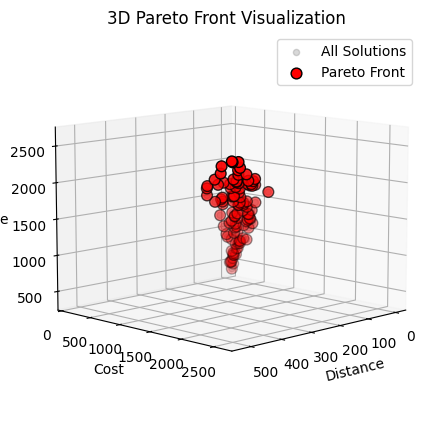

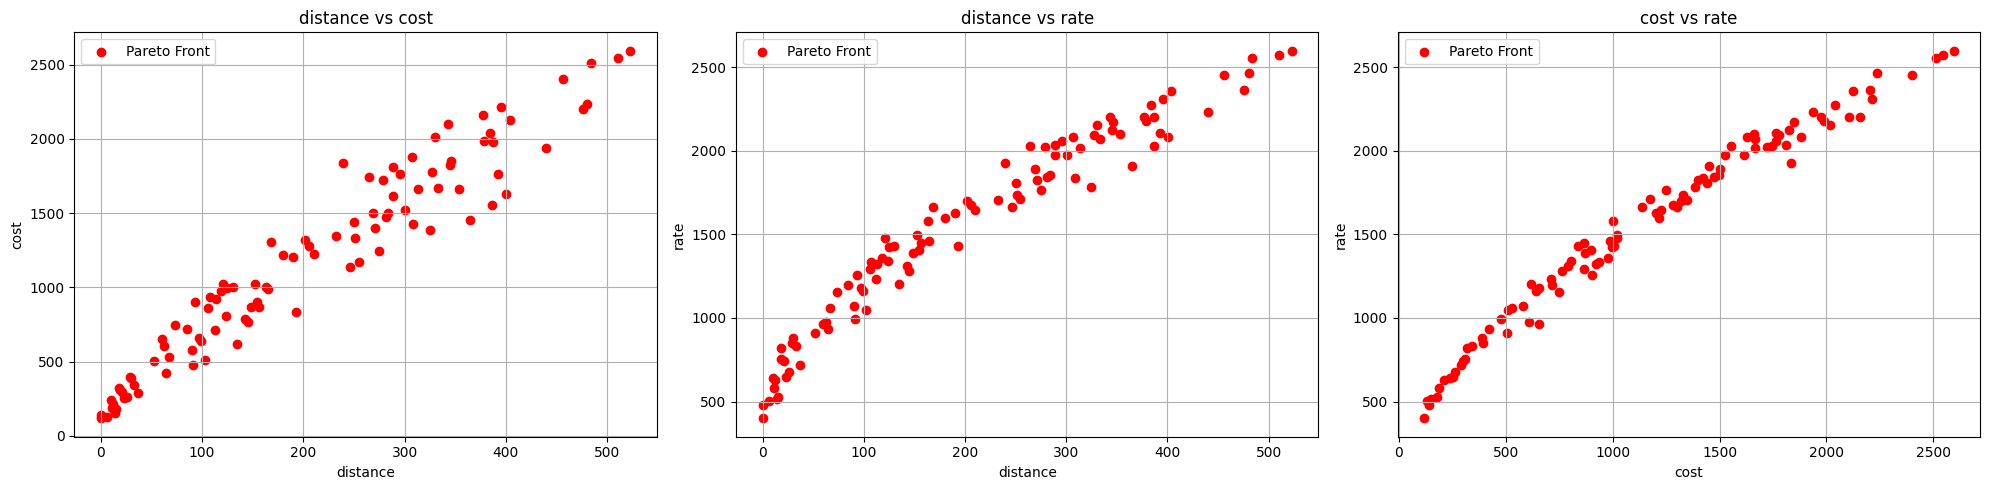

In [29]:
import random
import numpy as np
import folium
import matplotlib.pyplot as plt
import math
import ast

from os import replace
from pymoo.core.crossover import Crossover
from pymoo.core.problem import Problem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.population import Population
from pymoo.core.crossover import Crossover
from pymoo.operators.selection.rnd  import RandomSelection
from pymoo.core.sampling import Sampling
from geopy.distance import geodesic
from geopy.geocoders import ArcGIS
from geopy.geocoders import Nominatim
from pymoo.core.callback import Callback
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.core.selection import Selection
from pymoo.visualization.scatter import Scatter
from pymoo.core.mutation import Mutation
from mpl_toolkits import mplot3d
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from mpl_toolkits.mplot3d import Axes3D
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.util.dominator import Dominator
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from pymoo.termination.xtol import DesignSpaceTermination
from pymoo.termination.robust import RobustTermination

def repairSolution(solution, n_var):
   solution = [int(row) for row in solution]

   sample = np.zeros(n_var)


   if(solution[0] != 0):

        length = solution[0] * GeneticAlgorithmConfig.timePlaceMappingSize
        head, interior, tail = getSliceRoute(solution)
        uniqueList = []

        for i in range(0, len(interior),GeneticAlgorithmConfig.timePlaceMappingSize):

          if(interior[i] not in uniqueList):
            for j in range(i, i+GeneticAlgorithmConfig.timePlaceMappingSize, 1):
              uniqueList.append(interior[j])
        lengthSolution = int((len(uniqueList) // GeneticAlgorithmConfig.timePlaceMappingSize))

        uniqueList = [lengthSolution] + head + uniqueList + tail
        return uniqueList

   else:
      return solution


def isValidSolution(solution):
   solution = [int(row) for row in solution]
   return True



def createSolution(n_var):
    hotel = locations[locations["type"] == "hotel"].sample(n=1)
    hotelId = hotel["Id"].values[0]

    sample = [-1 for _ in range(n_var)]
    rand = random.randint(0, 20)
    time = np.random.randint(1, 8) * 15
    currentLocationSize = rand
    start = GeneticAlgorithmConfig.totalLocationSize + (GeneticAlgorithmConfig.hotelSize * GeneticAlgorithmConfig.timePlaceMappingSize)
    end = (start + (rand * GeneticAlgorithmConfig.timePlaceMappingSize))
    sample[0] = currentLocationSize
    sample[1] = hotelId
    sample[2] = time
    sample[end] = hotelId
    sample[end+1] = time
    for i in range(start, end, GeneticAlgorithmConfig.timePlaceMappingSize):
      location = locations[locations["type"] != "hotel"].sample(n=1)
      sample[i] = location["Id"].values[0]
      time = np.random.randint(1, 8) * 15
      sample[i+1] = time


    return sample

n_obj = 3
best_per_generation = []  # لیستی برای هر تابع هدف

def dominates(a, b):
    """بررسی اینکه آیا کروموزوم a بر کروموزوم b تسلط دارد یا خیر"""
    return np.all(a <= b) and np.any(a < b)



class CustomeCallback(Callback):
    def __init__(self, n_obj):
        super().__init__()
        self.n_obj = n_obj
        self.stop = False

    def notify(self, algorithm):

        combined_population = np.vstack([algorithm.pop.get("X"), algorithm.off.get("X")])

        # اصلاح جمعیت جدید
        new_population = np.zeros_like(combined_population)  # جمعیت جدید اصلاح‌شده

        for i in range(len(combined_population)):
            # اصلاح هر فرد از جمعیت
            individual = combined_population[i]

            # اصلاح فرد با استفاده از روش‌های مورد نظر (مثلاً ایجاد یک راه‌حل معتبر)
            # فرض کنید تابع اصلاحی createValidSolution این کار را انجام می‌دهد
            individual = repairSolution(individual, algorithm.problem.n_var)
            sample  = np.zeros(algorithm.problem.n_var)
            for j in range(len(individual)):
                sample[j] = individual[j]
            # اصلاح فرد در جمعیت جدید
            new_population[i] = sample
        F = np.zeros((new_population.shape[0], algorithm.problem.n_obj))
        algorithm.problem._evaluate(new_population, out={"F": F})


        if new_population.shape[0] == algorithm.pop.size:
            algorithm.pop.set("X", new_population)
        else:
            # اگر تعداد تغییر کرده، تعداد جمعیت را مطابق با نیاز تنظیم کنید
            algorithm.pop.set("X", new_population[:algorithm.pop.size])


        if algorithm.pop is not None:
            F = algorithm.pop.get("F")  # مقادیر تابع هدف
            X = algorithm.pop.get("X")


            pareto_indices = NonDominatedSorting().do(F, only_non_dominated_front=False)
            colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta']

            # ایجاد نمودار سه‌بعدی
            # fig = plt.figure(figsize=(10, 10))
            # ax = fig.add_subplot(111, projection='3d')
            # نمایش جبهه‌های پارتو به همراه مقادیر توابع هدف و کروموزوم‌هایی که تسلط دارند
            # for i, pareto in enumerate(pareto_indices):
            #     print(pareto)
                # color = colors[i % len(colors)]  # انتخاب رنگ به صورت چرخشی
                # for idx in pareto:
                #     ax.scatter(F[idx, 0], F[idx, 1], F[idx, 2], color=color, label=f'Pareto {i+1}' if idx == pareto[0] else "")

            # ax.view_init(elev=10, azim=45)
            # ax.set_title("Pareto Fronts in 3D")
            # ax.set_xlabel("Objective 1")
            # ax.set_ylabel("Objective 2")
            # ax.set_zlabel("Objective 3")

            # # حذف تکرار لیبل‌های رنگی
            # handles, labels = plt.gca().get_legend_handles_labels()
            # by_label = dict(zip(labels, handles))
            # plt.legend(by_label.values(), by_label.keys(), loc='upper left')

            # # نمایش نمودار
            # plt.show()
            # for i, pareto in enumerate(pareto_indices):
            #   print(f"Pareto Front {i+1}:")
            #   for idx in pareto:
            #       print(f"Index: {idx}, Objectives: {F[idx]}")
            #       # print(f"{X[idx]}")
            #       # بررسی تسلط کروموزوم‌ها در داخل همان جبهه
            #       for other_idx in pareto:
            #           if other_idx != idx and dominates(F[idx], F[other_idx]):
            #               print(f"  Dominates: Index {other_idx}, Objectives: {F[other_idx]}")
            #   print('------------')

            # print('//////////////////////////////////////////////')



class CustomMutation(Mutation):
    def __init__(self, mutation_rate=0.1):
        super().__init__()
        self.mutation_rate = mutation_rate  # احتمال جهش

    def _do(self, problem, X, **kwargs):
        X_mutated = X.copy()
        n, d = X.shape  # تعداد کروموزوم‌ها و متغیرها

        # for i in range(n):
        #     if np.random.rand() < self.mutation_rate:
        #         if X_mutated[i, 0] > 2:
        #           j = np.random.randint(2, X_mutated[i, 0])  # انتخاب یک ژن تصادفی برای تغییر
        #           X_mutated[i, j] = getLocation()
        return X_mutated



class CustomSampling(Sampling):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _do(self, problem, n_samples, **kwargs):
        n_var = problem.n_var  # تعداد متغیرها
        xl = problem.xl        # حد پایین متغیرها
        xu = problem.xu        # حد بالا متغیرها
        samples = np.zeros([n_samples, n_var], dtype=int)

        for row in range(len(samples)):
            samples[row] = createSolution(n_var)
        # print("created sample")
        # print(samples)
        # print('**********************************')
        return samples


def getObjective(routes, prefernces):
    total_distance = []
    total_cost = []
    total_rate = []



    for route in routes:

        countHotel = 0
        route = route.astype(int)
        distance = 0
        cost = 0
        rate = 0
        averageRate = 0
        startRoute = GeneticAlgorithmConfig.totalLocationSize
        endRoute  = (route[0] * GeneticAlgorithmConfig.timePlaceMappingSize) + GeneticAlgorithmConfig.totalLocationSize + (GeneticAlgorithmConfig.hotelSize * 2)


        # calculate distance
        for i in range(startRoute, endRoute, GeneticAlgorithmConfig.timePlaceMappingSize):


            start, end = int(route[i]), int(route[i + GeneticAlgorithmConfig.timePlaceMappingSize])

            start = locations[locations["Id"] == start]
            end = locations[locations["Id"] == end]

            start_lat, start_lon = start["Latitude"].values[0], start["Longitude"].values[0]
            end_lat, end_lon = end["Latitude"].values[0], end["Longitude"].values[0]

            distance += np.float64(geodesic((start_lat, start_lon), (end_lat, end_lon)).km)


        # caculate rate
        for i in range(startRoute,
                       endRoute,
                       GeneticAlgorithmConfig.timePlaceMappingSize):

          node = locations[locations["Id"] == route[i]]
          if(len(node["tag"]) > 0):
            tags = node["tag"].values[0]
            tags = tags.replace("[" ,"")
            tags = tags.replace("'" ,"")
            tags = tags.replace(']', "")
            tags = tags.replace(' ', "")
            tags = tags.split(',')
            for tag in tags:
              if(tag in prefernces):
                rate -=  node["Stars"].values[0] * prefernces[tag]
            averageRate = rate / len(tags)

            averageRate *= route[i+1]


        # caculate cost
        for i in range(startRoute,
                       endRoute,
                       GeneticAlgorithmConfig.timePlaceMappingSize):

            node = locations[locations["Id"] == route[i]]
            cost += node["Price"].values[0]


        total_distance.append(distance)
        total_cost.append(cost)
        total_rate.append(averageRate)

    return (total_distance, total_cost, total_rate)


# مدل و الگوریتم NSGA-II
class HotelRouteProblem(Problem):
    def __init__(self, n_var, prefernces=None):
      self.prefernces = prefernces
      super().__init__(n_var=n_var,
                         n_obj=3,
                         n_constr=0,
                         xl=0,
                         xu=len(locations) - 1)

    def _evaluate(self, x, out, *args, **kwargs):
        total_distance, total_cost, total_rate = getObjective(x, self.prefernces)
        out["F"] = np.column_stack([total_distance, total_cost, total_rate])

class CustomeCrossover(Crossover):
    def __init__(self):


        super().__init__(2,2)

    def _do(self, problem, X, **kwargs):

        _, n_matings, n_var = X.shape
        Y = np.full_like(X, None, dtype=object)

        for k in range(n_matings):
            while True:
              # انتخاب والدین
              parent1 = [int(item) for item in X[0, k]]
              parent2 = [int(item) for item in X[1, k]]

              head1, interior1, tail1 = getSliceRoute(parent1)
              head2, interior2, tail2 = getSliceRoute(parent2)

              point1 = 0
              point2 = 0
              if((len(interior1) // GeneticAlgorithmConfig.timePlaceMappingSize) > 0):
                  point1  = np.random.randint(0, len(interior1) / GeneticAlgorithmConfig.timePlaceMappingSize)

              if((len(interior2) // GeneticAlgorithmConfig.timePlaceMappingSize) > 0):
                point2 = np.random.randint(0, len(interior2) / GeneticAlgorithmConfig.timePlaceMappingSize)

              # print(f"parent1: {parent1}")
              # print(f"parent2: {parent2}")

              # display(HTML(f"""</span><span style='color:green'>{interior1[:point1*GeneticAlgorithmConfig.timePlaceMappingSize]}</span>
              #   <span style='color:orange'>{interior2[point2*GeneticAlgorithmConfig.timePlaceMappingSize:]}</span>"""))
              # display(HTML(f"""</span><span style='color:orange'>{interior2[:point2*GeneticAlgorithmConfig.timePlaceMappingSize]}</span>
              #   <span style='color:green'>{interior1[point1*GeneticAlgorithmConfig.timePlaceMappingSize:]}</span>"""))


              child1 = interior1[:point1*GeneticAlgorithmConfig.timePlaceMappingSize] + interior2[point2*GeneticAlgorithmConfig.timePlaceMappingSize:]
              child2 = interior2[:point2*GeneticAlgorithmConfig.timePlaceMappingSize] + interior1[point1*GeneticAlgorithmConfig.timePlaceMappingSize:]

              lenChild1 = int(len(child1) // GeneticAlgorithmConfig.timePlaceMappingSize)
              lenChild2 = int(len(child2) // GeneticAlgorithmConfig.timePlaceMappingSize)



              child1 = [lenChild1] + head1 + child1 + tail1
              child2 = [lenChild2] + head2 + child2 + tail2
              # print(f"child1: {child1}")
              # print(f"child2: {child2}")
              # print('--------------------------')
              childSample1  = np.zeros(n_var)
              childSample2  = np.zeros(n_var)

              child1 = repairSolution(child1, n_var)
              child2 = repairSolution(child2, n_var)




              for i in range(len(child1)):
                childSample1[i] = child1[i]
              for i in range(len(child2)):
                  childSample2[i] = child2[i]
              break

            # ذخیره فرزندان
            Y[0, k] = childSample1
            Y[1, k] = childSample2

        return Y


n_var = GeneticAlgorithmConfig.n_var




# استفاده از انتخاب تورنمنت


algorithm = NSGA2(pop_size=100,
                  sampling=CustomSampling(),
                  crossover=CustomeCrossover(),
                  callback=CustomeCallback(n_obj=3),
                  mutation=CustomMutation(mutation_rate=0.3),
                  )

userPreference = {"historical": 5,
                  "Recreational": 0.1,
                  "Natural": 0.1,
                  "Adventure": 0.1,
                  "Religious": 0.1,
                  "Resort": 1,
                  "Artistic": 0.1,
                  "Photography": 0.1,
                  "Cultural": 0.1}


termination = RobustTermination(DesignSpaceTermination(tol=0.01), period=20)

problem = HotelRouteProblem(n_var=n_var, prefernces=userPreference)
res = minimize(problem,
               algorithm,
               termination=termination,
               verbose=True,
               eliminate_duplicates=True)



best_index = np.argmin(res.F[:, 2])
best_route = res.X[best_index].astype(int)
best_distance = res.F[best_index, 0]
best_cost = res.F[best_index, 1]
best_rate = res.F[best_index, 2]



print('---------------')
print("Best Route (order of locations):", best_route)
print("Best Distance:", best_distance)
print("Best Cost:", best_cost)
print("Best rate:", abs(best_rate))




pareto_indices = NonDominatedSorting().do(res.F, only_non_dominated_front=True)
pareto_front = res.F[pareto_indices]


x = pareto_front[:, 0]
y = pareto_front[:, 1]
z = abs(pareto_front[:, 2])
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111, projection='3d')
# رسم نقاط
ax.scatter(res.F[:, 0], res.F[:, 1], abs(res.F[:, 2]), label="All Solutions", color="gray", alpha=0.3)
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], abs(pareto_front[:, 2]), label="Pareto Front", color="red", edgecolor="black", s=60)
# ax.scatter(x, y, z, c=z, cmap='viridis', s=10)  # s اندازه نقاط است
# تنظیم زاویه دید
ax.view_init(elev=10, azim=45)  # elev زاویه ارتفاع و azim زاویه افقی است
# نمایش نمودار
ax.set_xlabel("Distance")
ax.set_ylabel("Cost")
ax.set_zlabel("Rae")
ax.set_title("3D Pareto Front Visualization")
ax.legend()
plt.show()


plt.figure(figsize=(20, 5))

# هدف 1 مقابل هدف 2
plt.subplot(1, 3, 1)
# plt.scatter(res.F[:, 0], res.F[:, 1], c="gray", label="All Solutions")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c="red", label="Pareto Front")
plt.xlabel("distance")
plt.ylabel("cost")
plt.title("distance vs cost")
plt.legend()
plt.grid()

# هدف 1 مقابل هدف 3
plt.subplot(1, 3, 2)

plt.scatter(pareto_front[:, 0], abs(pareto_front[:, 2]), c="red", label="Pareto Front")
plt.xlabel("distance")
plt.ylabel("rate")
plt.title("distance vs rate")
plt.legend()
plt.grid()

# هدف 2 مقابل هدف 3
plt.subplot(1, 3, 3)
plt.scatter(pareto_front[:, 1], abs(pareto_front[:, 2]), c="red", label="Pareto Front")
plt.xlabel("cost")
plt.ylabel("rate")
plt.title("cost vs rate")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



# routePrefence = {}

# for i in range(1, best_route[0]+1):
#   location = locations[locations["Id"] == best_route[i]]

#   tags = location["tag"]
#   for index, values in tags.items():
#     value = values
#     value = value.replace("[" ,"")
#     value = value.replace("'" ,"")
#     value = value.replace(']', "")
#     value = value.replace(' ', "")
#     value = value.split(',')
#     for item in value:
#       if(item in routePrefence):
#           routePrefence[item] += 1
#       else:
#           routePrefence[item] = 1

# labels = list(routePrefence.keys())
# values = list(routePrefence.values())

# # رسم نمودار میله‌ای
# plt.figure(figsize=(8, 10))
# plt.bar(labels, values)

# # تنظیمات نمودار
# plt.xlabel("Preferences")
# plt.ylabel("Scores")
# plt.title("User Preferences for Tourism")
# plt.ylim(0, 15)  # تنظیم محدوده امتیازات
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # نمایش نمودار
# plt.show()

In [30]:
import folium

# ایجاد یک نقشه در مرکز اولین مکان
map_center = [locations["Longitude"].mean(), locations["Latitude"].mean()]
mymap = folium.Map(location=map_center, zoom_start=13)

for key in range(1, best_route[0] * 3, 3):

    location = locations[locations["Id"] == best_route[key]]
    color = 'blue'

    folium.Marker(
        location=[location["Longitude"].values[0], location["Latitude"].values[0]],
        popup= location["tag"].values[0],
        tooltip=f"{location['name'].values[0]}",
        icon=folium.Icon(color=color)
    ).add_to(mymap)


mymap




In [ ]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import numpy as np

# فرض کنید F ماتریس توابع هدف است (هر ردیف یک کروموزوم و هر ستون یک هدف)
F = np.array([
    [0.5, 0.5, 0.5],
    [0.2, 0.5, 0.5],
    [0.8, 0.2, 0.6],
    [0.6, 0.7, 0.9],
    [0.3, 0.9, 0.4],
    [0.4, 0.6, 0.2]
])

# اعمال مرتب‌سازی غیرمسلط
pareto_indices = NonDominatedSorting().do(F, only_non_dominated_front=False)

# تابع برای بررسی تسلط
def dominates(a, b):
    """بررسی اینکه آیا کروموزوم a بر کروموزوم b تسلط دارد یا خیر"""
    return np.all(a <= b) and np.any(a < b)

# نمایش جبهه‌های پارتو به همراه مقادیر توابع هدف و کروموزوم‌هایی که تسلط دارند
for i, pareto in enumerate(pareto_indices):
    print(f"Pareto Front {i+1}:")
    for idx in pareto:
        print(f"Index: {idx}, Objectives: {F[idx]}")
        # بررسی تسلط کروموزوم‌ها در داخل همان جبهه
        for other_idx in pareto:
            if other_idx != idx and dominates(F[idx], F[other_idx]):
                print(f"  Dominates: Index {other_idx}, Objectives: {F[other_idx]}")
    print('------------')

الگوریتم فازی - برای هر هتل سه مقدار بدبینانه،خوش بینانه و متوسط رو در نظر می گیریم

In [ ]:
import requests

# API Key خود را اینجا وارد کنید
API_KEY = '3k_wLMNf6CwujHWVLSLnoZFLnuDLAkzBrLxfZU9GT5cG2tkgngTk3YcAD80AUOTE665dznOmk1LXWbVHFvtBehmk-ao0Dnzo7urxabgbhvXWcDzWSRNWfvoXm-cDZ3Yx'

# URL پایه برای درخواست‌ها
url = 'https://api.yelp.com/v3/businesses/SoSQhqqOaS10aUuxDr1YtA'

# سربرگ‌ها (Headers) با کلید API
headers = {
    'Authorization': f'Bearer {API_KEY}',
}

# پارامترهای جستجو (می‌توانید موقعیت جغرافیایی، نوع کسب‌وکار و غیره را مشخص کنید)
params = {
    # 'term': 'hotels',   # نوع کسب‌وکار
    'location': 'New York',  # مکان
    'limit': 5               # تعداد نتایج
}

# ارسال درخواست به Yelp API
response = requests.get(url, headers=headers, params=params)

# بررسی وضعیت درخواست و چاپ نتایج
if response.status_code == 200:
    data = response.json()
    businesses = data.get('businesses')
    print(businesses)
    # for business in businesses:
    #     print(f"Name: {business['name']}, Rating: {business['rating']}, Address: {', '.join(business['location']['display_address'])}")
else:
    print(f"Error: {response.status_code}, {response.text}")


In [ ]:
filtered_df = locations[locations['tag'].apply(lambda x: 'restaurant')]
filtered_df

,Unnamed: 0,name,name:en,tag,type,Latitude,Longitude,Id,Stars,Price
603,603,خانه سنتی پرهامی,Parhami Traditional Hostel,"['restaurant', 'Resort']",restaurant,52.548575,29.610513,603,5,35
657,657,عمارت فیل,House of Elephant,"['restaurant', 'Resort']",restaurant,52.550227,29.611304,657,4,80
660,660,هتل سنتی آنا,Ana Traditional Hotel,"['restaurant', 'Resort']",restaurant,52.549947,29.608176,660,5,44
674,674,اقامتگاه سنتی ایران مهر,Iranmehr Boutique Hotel,"['restaurant', 'Resort']",restaurant,52.546682,29.614183,674,4,153
694,694,هتل عمارت قاجاریه,Ghajarieh Hotel,"['restaurant', 'Resort']",restaurant,52.545907,29.608112,694,1,168
706,706,خانه سنتی ملک,Malek Traditional House,"['restaurant', 'Resort']",restaurant,52.548940,29.610559,706,1,58
713,713,سرای آناهیتا,Anahita House,"['restaurant', 'Resort']",restaurant,52.547054,29.614590,713,2,73
